# UNET full flow tutorial

This tutorial will walk you through all the steps required to go from an ONNX file to a HEF file - parsing, quantizing and compiling the model.

In [1]:
import numpy as np
from IPython.display import SVG

from hailo_sdk_client import ClientRunner

## Parsing

Select the relevant inputs from your network:

In [2]:
model_name = 'ResNet18_CULanes'
onnx_path  = './culane_18.onnx'

output_node = ['Gemm_51']

Create the runner and parse the model:

In [3]:
runner = ClientRunner()
hn, npz = runner.translate_onnx_model(onnx_path=onnx_path, net_name=model_name, end_node_names=output_node)

[info] Restoring ONNX model ResNet18_CULanes from export file
[info] Translation started on ONNX model ResNet18_CULanes
[info] Translation completed on ONNX model ResNet18_CULanes
[info] Initialized runner for ResNet18_CULanes


See the model's profiler:

In [4]:
summary, details = runner.profile_hn_model(fps=30)

[info] 
Model Details
---------------------------  ----------
Input Tensors Shapes         288x800x3
Operations per Input Tensor  16.72 GOPs
Operations per Input Tensor  8.37 GMACs
Model Parameters             44.52 M
---------------------------  ----------

Profiler Input Settings
-----------------  ---------------
Optimization Goal  Reach 30.00 FPS
Profiler Mode      Pre Placement
-----------------  ---------------

Performance Summary
-------------------------------  -----------
Number of Devices                2
Throughput (Bottleneck Layer)    139.15 FPS
Latency                          15.41 ms
Total NN Core Power Consumption  0.51 W
Operations per Second            0.56 GOP/s
Operations per Second            0.28 GMAC/s
-------------------------------  -----------


ValueError: too many values to unpack (expected 2)

Save the parsed model in a Hailo Archive file:

In [5]:
hailo_model_har_name = '{}.har'.format(model_name)
runner.save_har(hailo_model_har_name)

Visualize the HN graph with the visualizer tool:

2022-05-21 19:19:28.802604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-21 19:19:28.802650: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


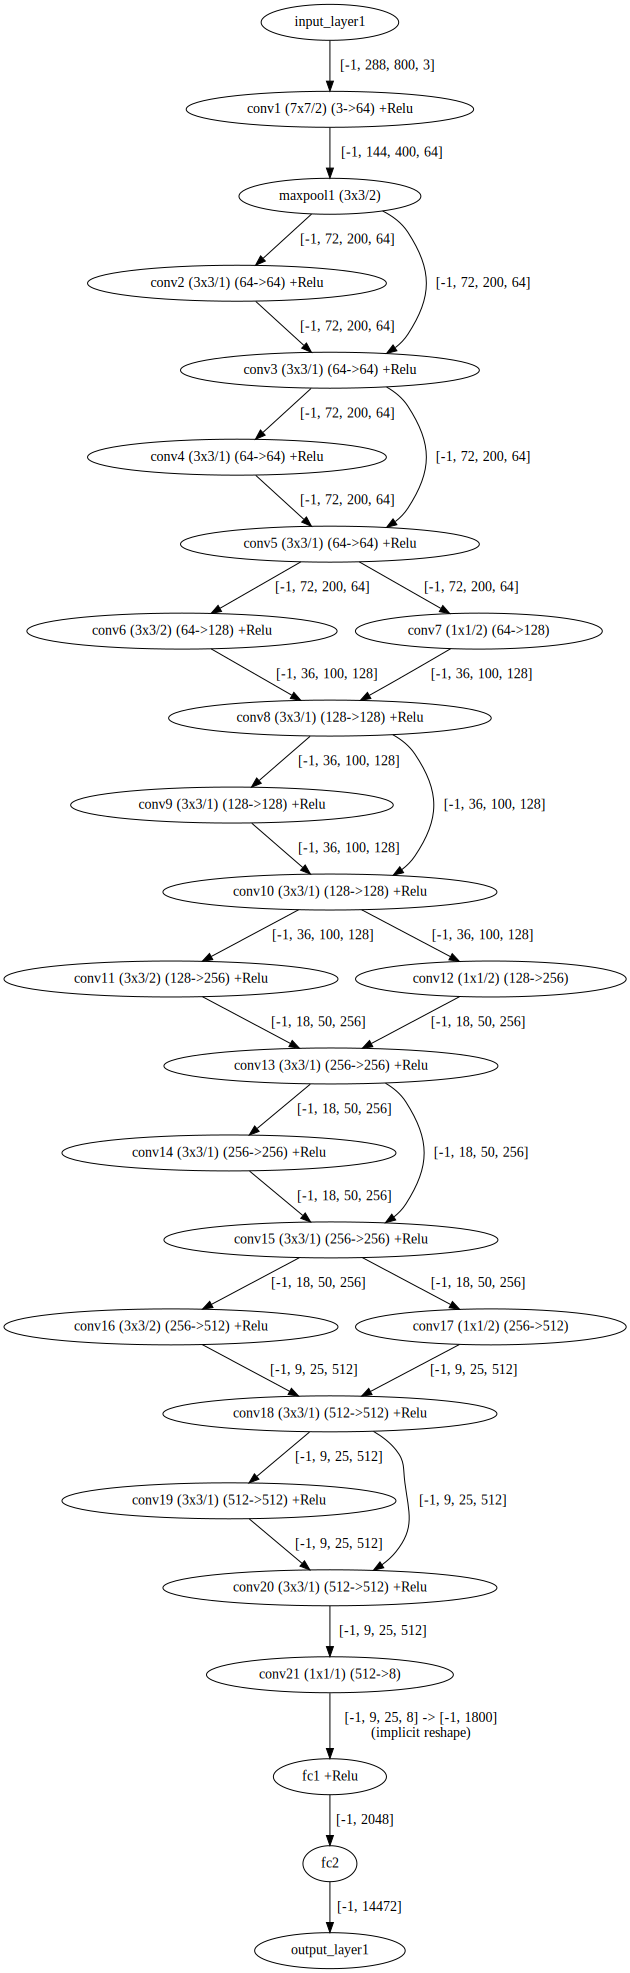

In [6]:
!hailo visualizer {hailo_model_har_name} --no-browser
SVG('out.svg')

## Quantization

Create pre-quantization script:

In [7]:
with open('ResNet18_CULane.q.alls', 'w') as FH: 
    FH.write('quantization_param(fc1, precision_mode=a8_w4)\n')
    FH.write('quantization_param(fc2, precision_mode=a8_w4)\n')

Notice that the calibration set is a randomly created data set, ment only for us to be able to quantize and compile the model. The model should be quantized with a real calibration data set.

Quantize the model:

In [11]:
%%time
calib_set = np.zeros((64, 288, 800, 3), dtype=np.float32)
runner.quantize(calib_data=calib_set, model_script='./ResNet18_CULane.q.alls')

[info] Loading model script on ResNet18_CULanes from ./ResNet18_CULane.q.alls
[info] Starting Quantization
[info] Using a calibration set of 64 entries for quantization
[info] Creating graph from hn
[info] Loading model configuration from config_file
[info] Loading params from npz
[warning] GPU policy set to enabled, no GPU detected
[info] Starting Equalization
[info] Creating graph from hn
[info] Loading model configuration from config_file
[info] Loading params from npz
[info] Equalization configuration:
[info]     Default policy: enabled
[info]     Mode: min_based
[info] Starting Equalization of component 1 out of 1
[info] The time for equalization 00:00:04.72
[info] Equalization is done
[info] Starting weights clipping
[info] Translating params for ResNet18_CULanes
[info] Creating graph from hn
[info] Loading model configuration from config_file
[info] Loading params from npz
[warning] for layer ResNet18_CULanes/conv1 data_input is all the same - changing to limvals [0.0, 1.0]
[inf

Save the quantized model in a Hailo Archive file:

In [12]:
hailo_quantized_model_har_name = '{}.q.har'.format(model_name)
runner.save_har(hailo_quantized_model_har_name)

## Compilation

In [13]:
with open('ResNet18_CULane.c.alls', 'w') as FH: 
    FH.write('allocator_param(timeout=5000)\n')
    FH.write('allocator_param(automatic_l4_portals=False)\n')
    FH.write('buffer_calc_param(optimize_buffers=True, split_aware_optimize_buffers=True)\n')
    FH.write('context_switch_param(max_compute_utilization=0.4, max_control_utilization=0.4, max_memory_utilization=0.4, max_utilization=1, mode=enabled)\n')
    FH.write('resources_param(strategy=greedy, max_control_utilization=0.6, max_compute_utilization=0.6, max_memory_utilization=0.6)\n')    
    FH.write('fc1_d0, fc1_d1, fc1_d2, fc1_d3, fc1_dc = defuse(fc1, 4, defuse_type=SPATIAL)\n') 
    FH.write('fc2_d0, fc2_d1, fc2_d2, fc2_d3, fc2_d4, fc2_d5, fc2_d6, fc2_d7, fc2_d8, fc2_d9, fc2_d10, fc2_d11, fc2_d12, fc2_d13, fc2_d14, fc2_d15, fc2_dc = defuse(fc2, 16, defuse_type=SPATIAL)\n')

Compile the model into a HEF file - This is the binary format that will be loaded into a Hailo8 device.

In [14]:
hef = runner.get_hw_representation(allocator_script_filename='./ResNet18_CULane.c.alls')

[warning] Taking model script commands from ./ResNet18_CULane.c.alls and ignoring previous allocation script commands


Save the HEF file:

In [15]:
file_name = model_name + '.hef'
with open(file_name, 'wb') as f:
    f.write(hef)

Save the compiled model in a Hailo Archive file:

In [16]:
hailo_compiled_model_har_name = '{}.c.har'.format(model_name)
runner.save_har(hailo_compiled_model_har_name)

Run inference to see FPS:

In [17]:
!hailortcli run ResNet18_CULanes.hef

Running streaming inference (ResNet18_CULanes.hef):
  Transform data: true
    Type:      auto
    Quantized: true
Network ResNet18_CULanes/ResNet18_CULanes: 20% | 61 | FPS: 60.99 | ETA: 00:00:04
Network ResNet18_CULanes/ResNet18_CULanes: 40% | 122 | FPS: 60.98 | ETA: 00:00:03
Network ResNet18_CULanes/ResNet18_CULanes: 60% | 182 | FPS: 60.65 | ETA: 00:00:02
Network ResNet18_CULanes/ResNet18_CULanes: 80% | 243 | FPS: 60.73 | ETA: 00:00:01
Network ResNet18_CULanes/ResNet18_CULanes: 100% | 304 | FPS: 60.78 | ETA: 00:00:00
> Inference result:
    Frames count: 304
    FPS: 60.79
    Send Rate: 336.16 Mbit/s
    Recv Rate: 7.04 Mbit/s
